# TIME SERIES FORECASTING -- SUPERSTORE CASESTUDY

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values. Some distinguishable patterns appear when we plot the data. 

The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year. We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

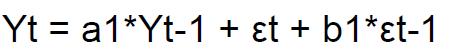

## OBJECTIVE : FORECASTING OF OFFICE SUPPLIES SALES FOR THE RETAIL STORE

### Import libraries

In [49]:
import os
import warnings                                                       # no warnings 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm                                          # Forcasting 
from pylab import rcParams                                            # setting up the charts/visualisation
from statsmodels.tsa.stattools import adfuller                        # stationarity
from numpy import log                                                 # stationarity
from pmdarima.arima.utils import ndiffs                               # stationarity/Differencing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf         # ACF and PACF plots
from statsmodels.tsa.arima_model import ARIMA                         # applying ARIMA
import pmdarima as pm                                                 # applying ARIMA

In [50]:
os.chdir(r'G:\Ivy Pro Data Science, AI and Machine L\PYTHON\010TIME_SERIES_FORECASTING\02Case1')
os.getcwd()

'G:\\Ivy Pro Data Science, AI and Machine L\\PYTHON\\010TIME_SERIES_FORECASTING\\02Case1'

### Import data

In [51]:
df = pd.read_excel("Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### Basic EDA

In [52]:
df.shape

(9994, 21)

In [53]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [54]:
#Let's take a look about the statistics of numeric values in the data.
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [55]:
df.Category.unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [56]:
df.Category.value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [57]:
# We will start our time series analysis on the Office Supplies.

In [58]:
# Extract the data of Office Supplies.
off = df.loc[df['Category'] == 'Office Supplies']

In [59]:
off.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656
8,9,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.504,3,0.2,5.7825
9,10,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.900,5,0.0,34.4700


In [60]:
off.shape

(6026, 21)

In [61]:
print(off['Order Date'].min())
print(off['Order Date'].max())

2014-01-03 00:00:00
2017-12-30 00:00:00


* We have a good 4-year Office Supplies sales data

In [62]:
off.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6026 entries, 2 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         6026 non-null   int64         
 1   Order ID       6026 non-null   object        
 2   Order Date     6026 non-null   datetime64[ns]
 3   Ship Date      6026 non-null   datetime64[ns]
 4   Ship Mode      6026 non-null   object        
 5   Customer ID    6026 non-null   object        
 6   Customer Name  6026 non-null   object        
 7   Segment        6026 non-null   object        
 8   Country        6026 non-null   object        
 9   City           6026 non-null   object        
 10  State          6026 non-null   object        
 11  Postal Code    6026 non-null   int64         
 12  Region         6026 non-null   object        
 13  Product ID     6026 non-null   object        
 14  Category       6026 non-null   object        
 15  Sub-Category   6026 n

In [63]:
#Checking Missing Values
off.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

## Data Pre-Processing

In [64]:
#Arranging the Data chronoligcally
off = off.groupby('Order Date')['Sales'].sum().reset_index()
off.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


In [65]:
#Indexing with Time Series
off = off.set_index('Order Date')
off.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,685.340
2014-01-07,10.430


In [66]:
off.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-16', '2014-01-18',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1148, freq=None)

As can be seen from the index, our current datetime data is not continuous and can be tricky to work with. Therefore, we will use the average daily sales value for that month instead, and we are using the start of each month as the timestamp. This requires us to resample the data.

In [67]:
# Average Monthly Sales
y = off['Sales'].resample('MS').mean()
y

Order Date
2014-01-01     285.357647
2014-02-01      63.042588
2014-03-01     391.176318
2014-04-01     464.794750
2014-05-01     324.346545
2014-06-01     588.774409
2014-07-01     756.060400
2014-08-01     541.879143
2014-09-01    1015.677704
2014-10-01     267.078815
2014-11-01     959.372714
2014-12-01     692.556231
2015-01-01     129.198571
2015-02-01     335.504187
2015-03-01     690.545522
2015-04-01     502.342320
2015-05-01     364.549440
2015-06-01     560.407737
2015-07-01     205.214739
2015-08-01     558.814667
2015-09-01     772.230680
2015-10-01     361.392083
2015-11-01     757.790357
2015-12-01     540.055800
2016-01-01     331.230125
2016-02-01     357.597368
2016-03-01     693.877240
2016-04-01     462.932478
2016-05-01     449.489724
2016-06-01     436.072400
2016-07-01     587.474727
2016-08-01     344.605385
2016-09-01     830.847786
2016-10-01     678.408083
2016-11-01     787.972231
2016-12-01    1357.055929
2017-01-01     967.013136
2017-02-01     389.882737
2

## Visualizing the Sales Time Series Data

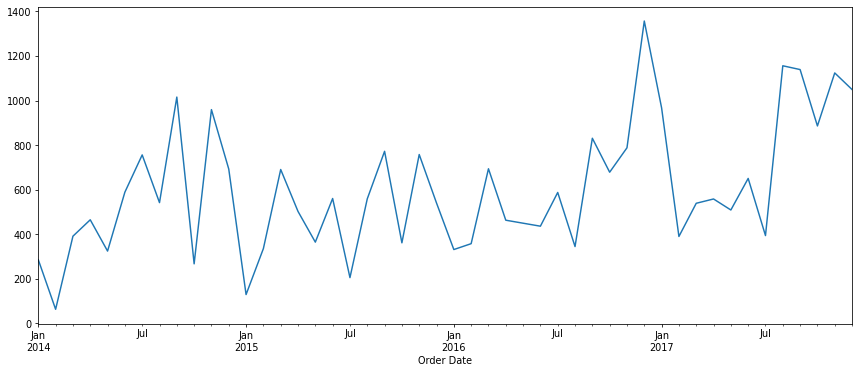

In [68]:
y.plot(figsize=(15, 6))
plt.show()

The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

## Decomposing the Data: Trend, Seasonal and Irregular Component

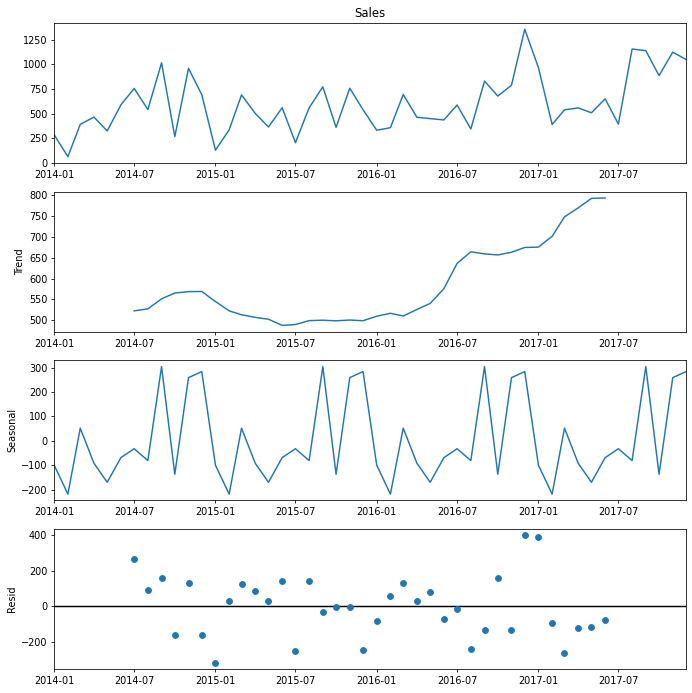

In [69]:
rcParams['figure.figsize'] = 10, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

We can observe from the abvove plots that there is seasonality in our data, and the trend is gradually increasing through the years.

## Checking the Stationarity of the Model

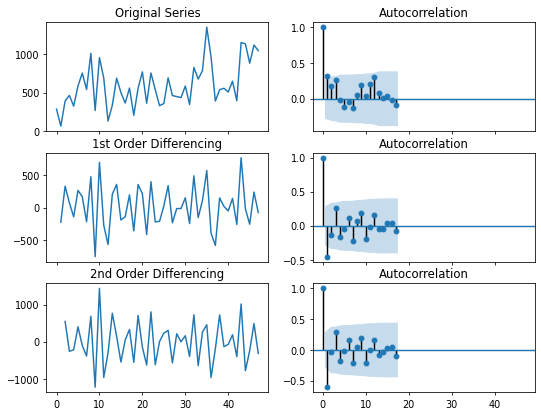

In [70]:
y_1 = y.reset_index()

# More Visualization
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':70})

#Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(y_1.Sales); axes[0, 0].set_title('Original Series')
plot_acf(y_1.Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_1.Sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_1.Sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_1.Sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_1.Sales.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### Augmented Dickey Fuller test

The Augmented Dickey-Fuller test is a type of statistical test alsocalled a unit root test.The base of unit root test is that it helps in determining how strongly a time series is defined by a trend.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary. The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis(H0): Time series is not stationary
Alternate Hypothesis (H1): Time series is stationary
This result is interpreted using the p-value from the test.

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data is stationary.

In [71]:
# augmented dickey fuller test
result_1 = adfuller(y_1.Sales.diff().dropna())
print('ADF Statistic: %f' % result_1[0])
print('p-value: %f' % result_1[1])

ADF Statistic: -8.603123
p-value: 0.000000


so we accept the alternative hypothesis: stationary

## Finding the AR Term of Model

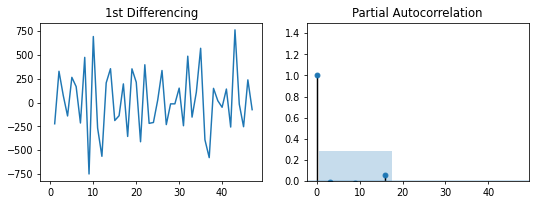

In [72]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':70})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_1.Sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.5))
plot_pacf(y_1.Sales.diff().dropna(), ax=axes[1])
plt.show()

PACF plot -- order of Auto Regressive (p)

## Finding the MA Term of Model

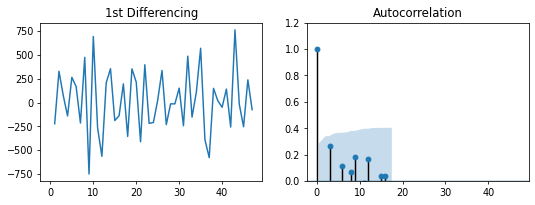

In [73]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_1.Sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_1.Sales.diff().dropna(), ax=axes[1])
plt.show()

ACF plot -- order of Moving Average (q)

## Fittting the SARIMA Model

In [98]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,  # not enforcing stationarity
                                enforce_invertibility=False) # models do converge

In [99]:
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2479      0.328      0.755      0.450      -0.395       0.891
ma.L1         -0.9389      0.462     -2.030      0.042      -1.845      -0.032
ar.S.L12      -0.6135      0.348     -1.762      0.078      -1.296       0.069
sigma2      7.421e+04   2.68e+04      2.768      0.006    2.17e+04    1.27e+05


Trend Elements
* p: Trend autoregression order.
* d: Trend difference order.
* q: Trend moving average order.

Seasonal Elements
* P: Seasonal autoregressive order.
* D: Seasonal difference order.
* Q: Seasonal moving average order.
* m: The number of time steps for a single seasonal period.

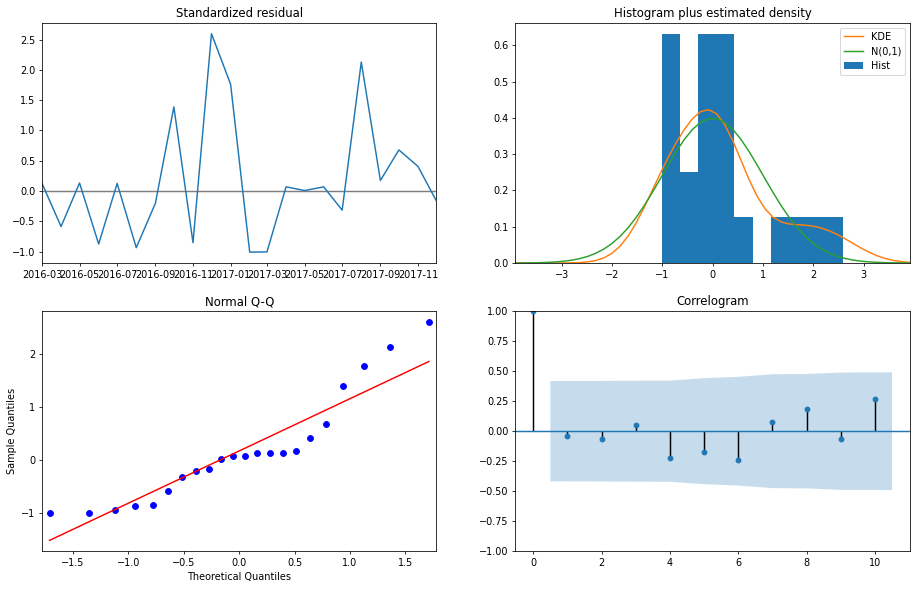

In [100]:
results.plot_diagnostics(figsize=(16, 10))
plt.show()

## Validating the Forecast for Office Supplies
we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

In [101]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)

            lower Sales  upper Sales
Order Date                          
2017-01-01   -61.399604  1021.629620
2017-02-01   127.920054  1208.787563
2017-03-01   276.381027  1355.437047
2017-04-01     0.848268  1078.375527
2017-05-01   -31.248125  1044.981272
2017-06-01    94.409742  1169.531720
2017-07-01   -56.529070  1017.643906
2017-08-01    36.614168  1109.970894
2017-09-01   555.485729  1628.138152
2017-10-01   164.855595  1236.898645
2017-11-01   477.680239  1549.194801
2017-12-01   559.947749  1631.003029


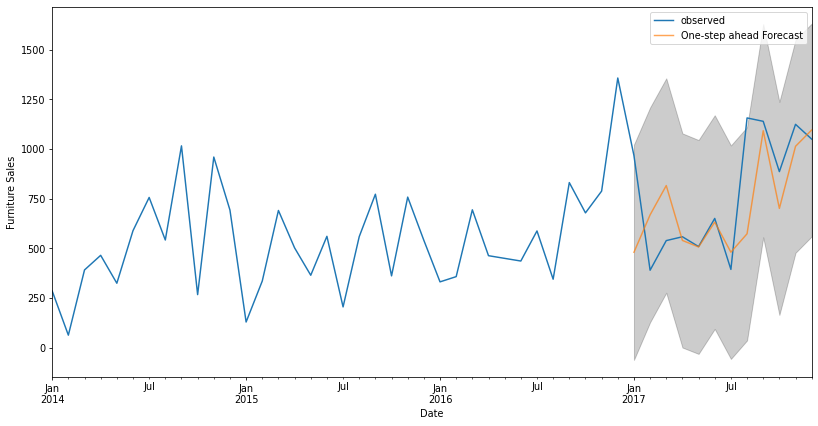

In [102]:
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

The grey area shows the confidence interval.

In [103]:
y_forecasted = pred.predicted_mean
y_forecasted

Order Date
2017-01-01     480.115008
2017-02-01     668.353808
2017-03-01     815.909037
2017-04-01     539.611897
2017-05-01     506.866573
2017-06-01     631.970731
2017-07-01     480.557418
2017-08-01     573.292531
2017-09-01    1091.811940
2017-10-01     700.877120
2017-11-01    1013.437520
2017-12-01    1095.475389
Freq: MS, dtype: float64

In [104]:
y_truth = y['2017-01-01':]
y_truth

Order Date
2017-01-01     967.013136
2017-02-01     389.882737
2017-03-01     538.899481
2017-04-01     558.229296
2017-05-01     508.776444
2017-06-01     650.463038
2017-07-01     393.902615
2017-08-01    1156.148154
2017-09-01    1139.137250
2017-10-01     886.045846
2017-11-01    1124.012036
2017-12-01    1049.549724
Freq: MS, Name: Sales, dtype: float64

In [105]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 65844.6


In [106]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 256.6


In [107]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

In [108]:
forecast_accuracy(y_forecasted, y_truth)

{'mape': 0.2428416150946824,
 'me': -63.648398763441094,
 'mae': 178.32524788868577,
 'mpe': 0.005828269175770969,
 'rmse': 256.6020270460664,
 'corr': 0.5564896419028877,
 'minmax': 0.20004058973426542}

## We are going to compare time series of office supplies and furniture.

In [110]:
# Extract the data of Furniture
furniture = df.loc[df['Category'] == 'Furniture']

In [111]:
#Arranging the Data chronoligcally
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [112]:
#Indexing with Time Series
furniture = furniture.set_index('Order Date')
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [114]:
y_furniture = furniture['Sales'].resample('MS').mean()

In [115]:
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y.index, 'Sales': y.values})

In [117]:
store = furniture.merge(office, how = 'inner', on = 'Order Date')
store.rename(columns = {'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049187,324.346545


## Visualizing the Sales Data for Furniture and Office Supplies

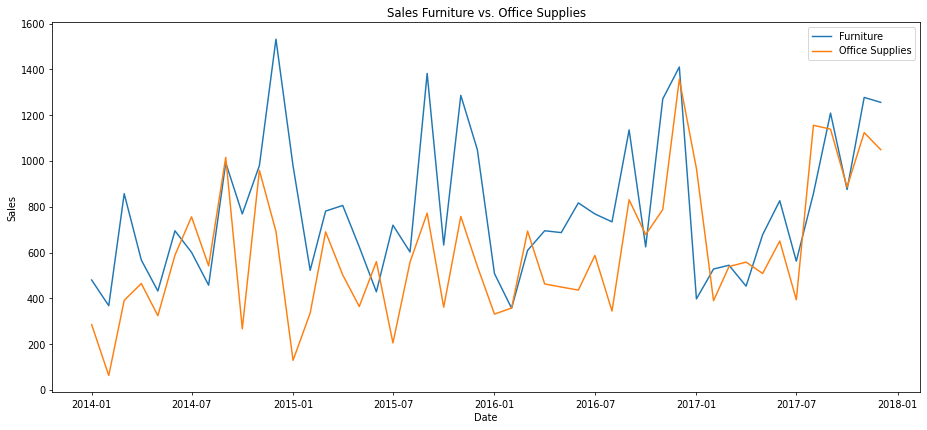

In [122]:
plt.figure(figsize = (16, 7))
plt.plot(store['Order Date'], store['furniture_sales'], label = 'Furniture')
plt.plot(store['Order Date'], store['office_sales'],  label = 'Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Furniture vs. Office Supplies')
plt.legend()
plt.show()

## INSIGHTS

* We observe that sales of office supplies have a seasonal pattern


* The average daily sales for furniture are higher than those of office supplies in most of the months.


* Early of the year is the off season for office supplies category. It seems summer time is quiet for office supplies.


* The sales are generally low at the beginning of every year as evident from decreasing line slope at the onset of year 2014, 2015, 2016 etc.